# **Random Forest Classifier Twitter ‘Social Spambots’**
## By:  Joaquin Quintana & Jason Weidner

In [1]:
from IPython.display import Image
import matplotlib.pyplot as plt
from zipfile import ZipFile
import seaborn as sns
import pandas as pd
import numpy as np
import os

Here we look at using a RandomForest Classifier using Sklearn and the attributes mentioned below. The attributes mentioned showed a high level of success in past academic research, [Cresci Fame for Sale 2015 paper](https://www.sciencedirect.com/science/article/abs/pii/S0167923615001803?via%3Dihub) and this is the reason they why they were chosen for modeling here.

#### Attributes which show a high level of success 

1. **number of friends:** spambots do not have thousands of friends

2. **number of tweets:** spambots have sent less than 20 tweets

3. $\frac{friends}{followers^2}$: spambots have a high $\frac{friends}{followers^2}$ ratio value (i.e., lower ratio values means legitimate users).

4. **favourites_count:** The number of Tweets this user has liked in the account’s lifetime. British spelling used in the field name for historical reasons. 


# Need to input now that functions are fixed

In a second note book we computed the **Information Gain** for the following attributes. 

## **Begin Function Defintions for Notebook**

In [2]:
#Template for function defintions; Note: May consider making the whole directory a file path so all files are found regardless of location. 
def navigator():
    """Changes your current working directory to the one containing unziped data file.
    
    Parameters:
        attr_col (N/A): Navigates from the directory containing the python notebook up one leve to the 
        folder 'data'. This folder contains the zip file with the raw data. Simply run the function after 
        folders are in aforementioned stucture (see schematic above).
    
    Returns: 
        (string): Prints the working directory. The new path is added to the working directory.
        
    Note:
        - This function will change the working directory and keep the notebook on the path to the data
        folder. Allows for the notebook to access the data file remotely. 
    """
    path_parent = os.path.dirname(os.getcwd()) # get directory notebook 
    
    # Find folder named data 
    f = os.path.join(os.path.expanduser('~'),path_parent,'data')
    os.chdir(f)
    
    return(f)

In [3]:
def unzip_all_zips(Zip_File_Name):
    """ Recursively open all zipfiles in the working directory and the subsequent sub directories. 
    
    Parameters:
        attr_col (string): input zip folder's name. For example, 'folderName.zip'
    
    Returns: 
        (string): Print "Done!" When finished opening files.
        
    Note:
        - This function will open all folders with ext .zip. 
        Warning! - function will overwrite all data with identical folder names 
    """
    # specifying the zip file name 
    folder = Zip_File_Name 
    
    # opening the zip file in READ mode 
    with ZipFile(folder, 'r') as zip:
        zip.extractall() 

    #navigate into subdirectory
    os.chdir('datasets_full.csv')
    path = os.getcwd()
    
    #get all files in subdirectory 
    all_files = os.listdir('.')
    all_zip_files = [file for file in all_files if file.endswith('.zip')] # find only the zip files
    
    #open all identified zip files in subdriectory
    for file in all_zip_files:
        with ZipFile(file, 'r') as zip: 
            zip.extractall() 
            
    return("Done!")

In [4]:
def create_col_target_column_rf(df_real_users,df_bot):
    """Creates a df with two columns: "id" and "bot" (AKA target) column.
    This is, if a bot return 1 and if not a bot account return 0.
    
    Parameters:
        df (pd.df): takes two dataframes with at least two columns; one that is real users and the other which are known bots.
        
    Returns:
        df (pd.df): a dataframe with two columns: "id" and "Bot".
        
    Note: 
    """
    
    data = df_real_users
    real_users_only = data.assign(bot=0) # create column of zeros named 'bot'

    data_bot = df_bot
    bot_only = data_bot.assign(bot=1) # create column of ones named 'bot'
    
    # concat df's, one on top of the other
    real_users_and_trad_bot = pd.concat([bot_only,real_users_only], axis=0) 
    real_users_and_trad_bot.set_index(keys="id")
    
    return real_users_and_trad_bot

In [5]:
#JQ
# friends_count: The number of users this account is following (AKA their “followings” or "friends").
# followers_count: how many users follow this user (AKA followers).
def frame_friends_square_followers_ratio(df):
    """Creates a df with two columns: "id" and the computed ratios for (friends) / (followers^2) as a float.
    
    Parameters:
        df (pd.df): a dataframe with at least three columns: "id" and "friends_count", "followers_count"
        
    Returns:
        df (pd.df): a dataframe with two columns: "id" and ratios for (friends) / (followers^2) as a float.
    """
    #columns you want to pull from csv file 
    list_of_columns = ['id','friends_count','followers_count']

    #return pandas dataframe with select columns. 
    df_select_col = df[list_of_columns]
    
    #compute friends/followers^2 ratio
    friends_followers_ratio = df_select_col.friends_count/df_select_col.followers_count**2
    
    #drop columns which are no longer needed
    df_select_col = df_select_col.drop(['friends_count', 'followers_count'], axis=1)
    
    #create new column to place ratio
    df_select_col['friends/followers^2'] = friends_followers_ratio
    
    #return the data frame with "id" and "friends/followers^2"
    return df_select_col

In [6]:
#Helper function JQ
def Compute_all_attributes_RF(df_real_users,df_bot):
    """Creates a df with two columns: "id" and target column this is, if a bot account 1 and if not 0.
    
    Parameters:
        df (pd.df): takes two dataframes with at least two columns in each; 
        one that is real users and the other which are known bots.
        
    Returns:
        df (pd.df): a dataframe with two columns: "id" and "Bot".
        
    Note: 
    """
    
    ratio_id = frame_friends_square_followers_ratio(df_real_users)
    #drop id as row are identical in both cases so can just concatenate the ratio onto other Dataframe
    ratio = ratio_id.drop(columns = "id")
    #get columns from original data
    l = ['id','friends_count','favourites_count','followers_count']
    df = df_real_users[l]
    real = df.copy()
    #concatenate column onto dataframe with other columns
    real['friends/followers^2'] = ratio
    real
    
    ratio_id_bot = frame_friends_square_followers_ratio(df_bot)
    #drop id as row are identical in both cases so can just concatenate the ratio onto other Dataframe
    ratio_bot = ratio_id_bot.drop(columns = "id")
    #get columns from original data
    l = ['id','friends_count','favourites_count','followers_count']
    df = df_bot[l]
    bot = df.copy()
    #concatenate column onto dataframe with other columns
    bot['friends/followers^2'] = ratio_bot
    bot

    #concatenate real and bot profiles. Assign a target column 1 for bot 0 for not
    data_all = create_col_target_column_rf(real,bot)
    return data_all

# **Directory setup for this script**

### Schematic of folder structure expected for running this mining tool. 

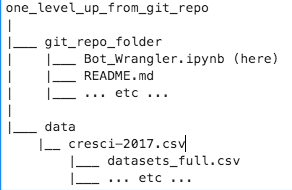

In [7]:
#placed image in folder with this python notebook for user to run and see prior to opening any files
Image(filename = 'Folder Structure Bot_Wrangler.png')

### 1. Use navigator and  then run the function unzip_all_zips.  

#### **Note:** Navigator assumes your starting with the raw unzipped file each time.

In [8]:
#find data folder and to path
navigator()

'/Users/JQ/Documents/Data_Mine/Bots_Project/data'

### 2. This will open all zip files and any file can be accessed by placing the filePath after os.getcwd(), this is as a string.

In [9]:
#unzip all files with the zip ext. Add to file Path
unzip_all_zips('cresci-2017.csv.zip')

'Done!'

### Constants to make things easy to access all files after unzipping files. 

In [10]:
#After running bnavigator and unzipping files we can use the following constants to find all csv files on file path
REAL_USERS = os.getcwd() + '/genuine_accounts.csv/users.csv'
REAL_TWEETS = os.getcwd() + '/genuine_accounts.csv/tweets.csv'

SOCIAL_USERS_1 = os.getcwd() + '/social_spambots_1.csv/users.csv'
SOCIAL_USERS_2 = os.getcwd() + '/social_spambots_2.csv/users.csv'
SOCIAL_USERS_3 = os.getcwd() + '/social_spambots_3.csv/users.csv'

SOCIAL_TWEETS_1 = os.getcwd() + '/social_spambots_1.csv/tweets.csv'
SOCIAL_TWEETS_2 = os.getcwd() + '/social_spambots_2.csv/tweets.csv'
SOCIAL_TWEETS_3 = os.getcwd() + '/social_spambots_3.csv/tweets.csv'

TRAD_USERS_1 = os.getcwd() + '/traditional_spambots_1.csv/users.csv'
TRAD_USERS_2 = os.getcwd() + '/traditional_spambots_2.csv/users.csv'
TRAD_USERS_3 = os.getcwd() + '/traditional_spambots_3.csv/users.csv'
TRAD_USERS_4 = os.getcwd() + '/traditional_spambots_4.csv/users.csv'

TRAD_TWEETS_1 = os.getcwd() + '/traditional_spambots_1.csv/tweets.csv'
TRAD_TWEETS_2 = os.getcwd() + '/traditional_spambots_2.csv/tweets.csv'
TRAD_TWEETS_3 = os.getcwd() + '/traditional_spambots_3.csv/tweets.csv'
TRAD_TWEETS_4 = os.getcwd() + '/traditional_spambots_4.csv/tweets.csv'

## Read in a few files

In [11]:
real_users = pd.read_csv(REAL_USERS)
#real_tweets = pd.read_csv(REAL_TWEETS)

tradbot_1 = pd.read_csv(TRAD_USERS_1)
tradbot_2 = pd.read_csv(TRAD_USERS_2)
tradbot_3 = pd.read_csv(TRAD_USERS_3)
tradbot_4 = pd.read_csv(TRAD_USERS_4)

socbots_1 = pd.read_csv(SOCIAL_USERS_1)
socbots_2 = pd.read_csv(SOCIAL_USERS_2)
socbots_3 = pd.read_csv(SOCIAL_USERS_3)

# Begin Exploratory Analysis

### First lest look at each files number of entries (AKA user accounts). 

In [55]:
l = [real_users,tradbot_1,tradbot_2,tradbot_3,tradbot_4,socbots_1,socbots_2,socbots_3]
size = []
#get the number of rows in each file
for name in l:
    size.append(name.id.shape[0])
    
#place x labels and convert to Dataframe
labels = ['real_users','tradbot_1','tradbot_2','tradbot_3','tradbot_4','socbots_1','socbots_2','socbots_3']
dat = pd.DataFrame(size,labels)

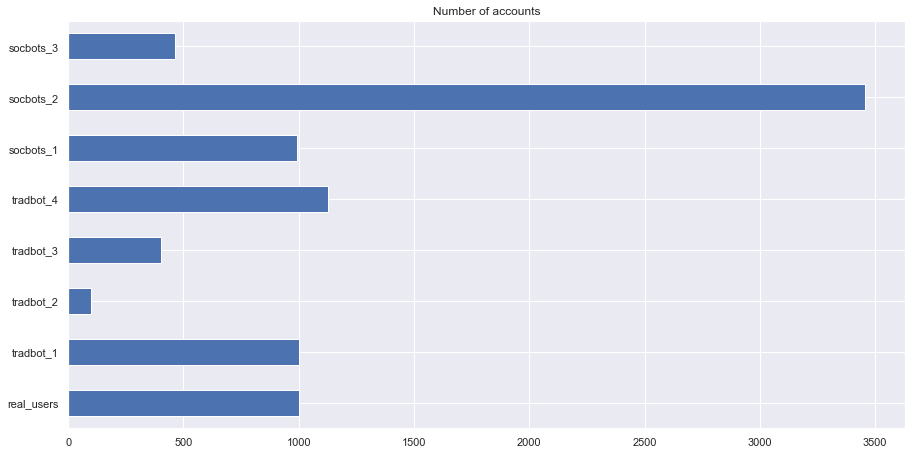

In [56]:
#plot bar chart showing the sizes of each file
dat.plot.barh(legend=False,figsize=(15,7.5));
plt.title('Number of accounts');

In [57]:
#We have unbalnced data so might combine to make the number of bots and real users more similar in number of accounts.  
real_users = real_users.sample(n=1000)
real_users.shape

(1000, 42)

In [58]:
real_user_andBots1 = Compute_all_attributes_RF(real_users,socbots_1)
real_user_andBots1 = real_user_andBots1.reset_index(drop=True)

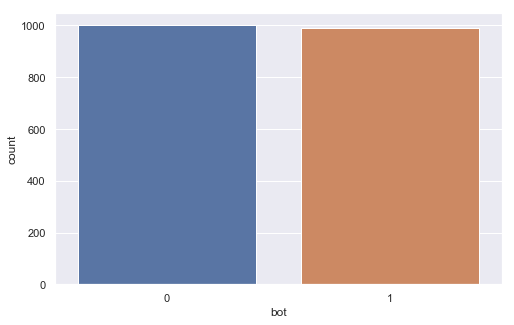

In [59]:
sns.countplot(x="bot", data=real_user_andBots1);

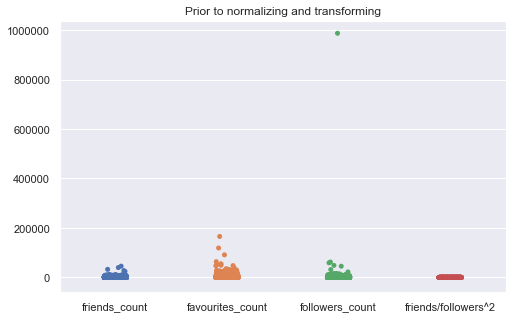

In [60]:
## Now display the data as is prior to preprocessing 
X = real_user_andBots1[[ 'friends_count', 'favourites_count', 'followers_count',
       'friends/followers^2']]
sns.set(rc={'figure.figsize':(8,5)})
sns.stripplot(data = X)
plt.title('Prior to normalizing and transforming');

## Process data by scaling and transforming


Above I selected four variables to work with from the datasets and I will perform this Random Forest Classification on datasets with both traditional and social spambots to see how well or accurate the model is at differatiating real users from bots given the attributes selected. 

First we will need to specify which factors we want to use in this Random Forest Classifier and these are assigned to X. The target or ground truth values are set to y and is binary. Sklearn likes this data to be in a specific shape and assumes the data is normalized for each factor to make comparison between groups relevant. 

From [Sklearn's documentaion](https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing) : The sklearn.preprocessing package provides several common utility functions and **transformer classes to change raw feature vectors into a representation that is more suitable for the downstream estimators.**

In general, **learning algorithms benefit from standardization of the data set.** If some outliers are present in the set, robust scalers or transformers are more appropriate.

## Begin Preprocessing using sklearn

In [61]:
import sklearn
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

## Clean data as there are a few NaNs so I'll simply drop these rows as the dataset is large.

In [62]:
#there are some nans in the rows so I'll drop all rows which have any nana
print('Are there NaNs in this Data: ',real_user_andBots1.isnull().values.any())
real_user_andBots1 = real_user_andBots1.dropna()
real_user_andBots1.isnull().values.any()
print('After droping Nans - are there NaNs in this Data: ',real_user_andBots1.isnull().values.any())

Are there NaNs in this Data:  True
After droping Nans - are there NaNs in this Data:  False


## Training and Test Set Preparation

First I use [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) from sklearn to randomly split the data into two sets. Set one contains 30% of the data (used for testing) and set two holds the other 70%  of the data (used for training). This is performed so we can use one set for training and the other set to test with, which ensures we are not performing both analysis on the same fraction of data. 

In [63]:
## Begin splitting data
X = np.asarray(real_user_andBots1[[ 'friends_count', 'favourites_count', 'followers_count',
       'friends/followers^2']])
y = np.asarray(real_user_andBots1['bot'])

# Use Train and Test split to split the data into two sets.
X_train, X_test, y_train, y_test = train_test_split( 
        X, y, test_size = 0.3)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (1181, 4) (1181,)
Test set: (507, 4) (507,)


# Preprocessing data

Preprocessing can be done using sklearns [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) and [transform](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler.transform) which scale the data to unit variance and then transform the data. This is, each factor is taken independently, scaled and transformed to a normal distribution with mean = 0 and standard deviation = 1. The data is also fit to the model using sklearns fit function. 

The reason we perform this preprcoessing is to ensure all the values are within a scale that can be used to make comparisons between factors which may have wildly differing units or scales which would be erronous to compare.

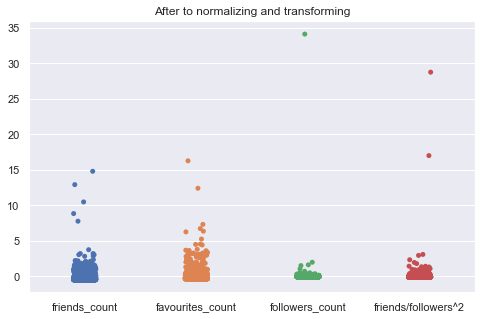

In [64]:
#preprocess the train and test sets
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#show the data after processing
labels = ['friends_count', 'favourites_count', 'followers_count',
       'friends/followers^2']

df = pd.DataFrame(X_train,columns = labels)
sns.set(rc={'figure.figsize':(8,5)})
plt.title('After to normalizing and transforming');
sns.stripplot(data = df);

## Begin Random Forest Classification


We can set a few of the parameters going into the Random Forest Classifier. Here I allow n_estimators = 50 which is the number of trees to consider in the forest. Random_state = 10, which controls the bootstrapping of the samples used when building trees and the features to consider when looking for the best split at each node (also provides back the same result each time if a value is specified; important for reproducability otherwise each time it will return a different result). Max_depth contols the size of the trees which can be made. It is pretty straight forward and works ok as is.

Return the Test Score and Train Score after fitting.

In [65]:
rf= RandomForestClassifier(n_estimators = 50, random_state=20,max_depth=5) #n_estimator = DT
rf.fit(X_train,y_train) # learning

print("Random Forest Test Score: ",rf.score(X_test,y_test))
print("Random Forest Train Score: ",rf.score(X_train,y_train))

Random Forest Test Score:  0.9625246548323472
Random Forest Train Score:  0.97883149872989


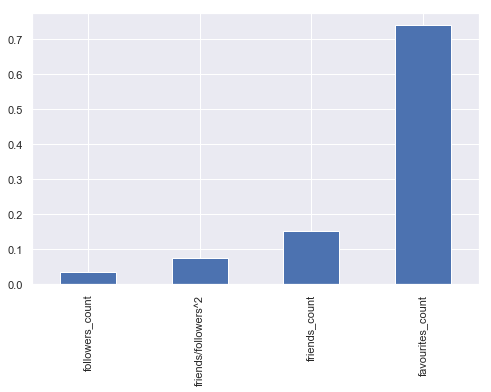

In [66]:
importances = rf.feature_importances_
importances = pd.DataFrame(importances,['friends_count', 'favourites_count', 'followers_count',
       'friends/followers^2'])
importances=importances.rename(columns={0: "Features_Importance"})
importances  = importances.Features_Importance.sort_values()
importances.plot.bar();

Let's look at the confusion matrix to get more details on how well this model does. 
Using [sklearn confusion matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html), which can be interpreted as (from sklearn documentation): In binary classification, the count of **true negatives:** $C(0,0)$, **false negatives:** is $C(0,1)$, **true positives:** is $C(1,0)$ and **false positives:** is $C(1,1)$. Often times people are looking simply at the dignoal with hopes that the majority of the data is falling along the diagnoal which is **true negatives:** $C(0,0)$ and  **true positives:** is $C(1,0)$.

Below the confusion matrix the classification report is printed out showing the precision, recall, F1-score and the score. 

The *precision* and *recall* can be combined into something called the $F_1$ score. This is $$F_1 = \frac{2}{1/\textrm{recall} + 1/\textrm{precision}}.$$ 

This takes on value '1' for best and '0' for worst precision & recall -- i.e. it's a single "higher is better" metric to avoid making two comparisons.

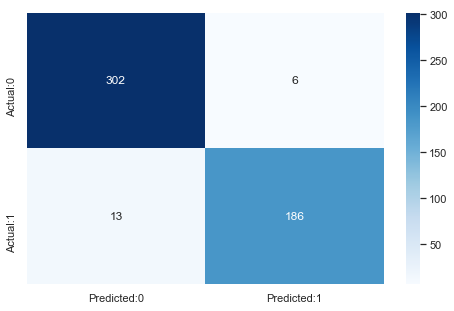

302

In [84]:
#predict how well model fits the known data.
y_pred = rf.predict(X_test)

# Confusion matrix 
from sklearn.metrics import confusion_matrix, classification_report
  
cm = confusion_matrix(y_test, y_pred)
conf_matrix = pd.DataFrame(data = cm, 
                           columns = ['Predicted:0', 'Predicted:1'], 
                           index =['Actual:0', 'Actual:1'])
plt.figure(figsize = (8, 5))
sns.heatmap(conf_matrix, annot = True, fmt = 'd', cmap = "Blues")
plt.show()
  
#print('Classification Report: =')
#print (classification_report(y_test, y_pred))



**True Negative**  | **False Postive**

**False Negative** | **True Postive**  

In [92]:
print('This is of the', cm[0,0], 'real users only', cm[0,1], 'were misclassified as bots and of the', cm[1,1], 'bots only', cm[1,0],'were misclassified as real users.')

This is of the 302 real users only 6 were misclassified as bots and of the 186 bots only 13 were misclassified as real users.


## Results for Random Forest Classifier using four attributes: 
1. number of friends 

2. number of tweets 

3. $\frac{friends}{followers^2}$ 

4. favourites_count.

Breifly, this can be interpreted as:

* **True Negative:** number of real users determined by the classifier to be real users

* **True Positive:** number of bots determined by the classifier to be bots

* **False Positive:** number real users determined by the classifier to be bots

* **False Negative:** number bots recognized by the classifier to be real users

Using the four attibutes we see that the accuracy for the Random Forest Classifier is ~0.96 using the testing data. Overall, this is realtivley high score and is showing good results with regards to classifying real user from bots based on the four attributes.  

# Drop most important factor and see how this effects the model
Most important factor is favorites count so this will be dropped. 

In [36]:
real_user_andBots1 = Compute_all_attributes_RF(real_users,socbots_1)
real_user_andBots1 = real_user_andBots1.reset_index(drop=True)

In [26]:
#there are some nans in the rows so I'll drop all rows which have any nana
print('Are there NaNs in this Data: ',real_user_andBots1.isnull().values.any())
real_user_andBots1 = real_user_andBots1.dropna()
print('Are there NaNs in this Data: ',real_user_andBots1.isnull().values.any())

X = np.asarray(real_user_andBots1[[ 'friends_count', 'followers_count',
       'friends/followers^2']])
y = np.asarray(real_user_andBots1['bot'])

## Begin splitting data
# Use Train and Test plit to split the data into two sets.
X_train, X_test, y_train, y_test = train_test_split( 
        X, y, test_size = 0.3)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Are there NaNs in this Data:  True
Are there NaNs in this Data:  False
Train set: (1181, 3) (1181,)
Test set: (507, 3) (507,)


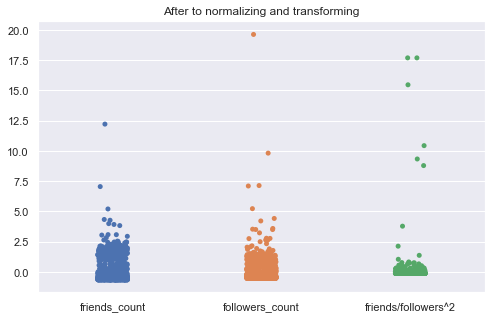

In [27]:
#preprocess the train and test set to avoid max iter warning. 
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#show the data after processing
labels = ['friends_count', 'followers_count',
       'friends/followers^2']

df = pd.DataFrame(X_train,columns = labels)
sns.set(rc={'figure.figsize':(8,5)})
plt.title('After to normalizing and transforming');
sns.stripplot(data = df);

Random Forest Test Score:  0.8106508875739645
Random Forest Train Score:  0.8450465707027942


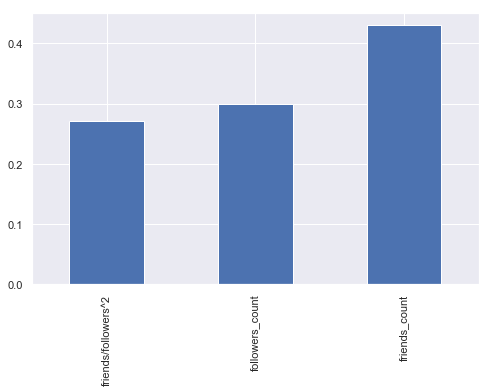

In [28]:
rf= RandomForestClassifier(n_estimators = 50, random_state=20,max_depth=5) #n_estimator = DT
rf.fit(X_train,y_train) # learning

print("Random Forest Test Score: ",rf.score(X_test,y_test))
print("Random Forest Train Score: ",rf.score(X_train,y_train))

importances = rf.feature_importances_
importances = pd.DataFrame(importances,['friends_count', 'followers_count',
       'friends/followers^2'])
importances=importances.rename(columns={0: "Features_Importance"})
importances  = importances.Features_Importance.sort_values()
importances.plot.bar();

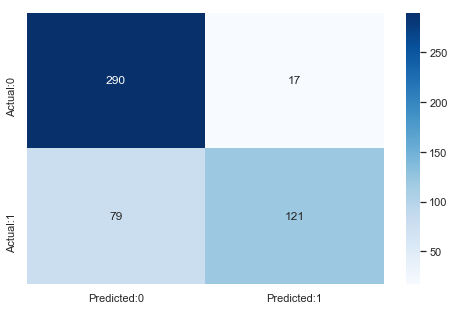

Classification Report: =
              precision    recall  f1-score   support

           0       0.79      0.94      0.86       307
           1       0.88      0.60      0.72       200

    accuracy                           0.81       507
   macro avg       0.83      0.77      0.79       507
weighted avg       0.82      0.81      0.80       507



In [30]:
#predict how well model fits the known data.
y_pred = rf.predict(X_test)

# Confusion matrix 
from sklearn.metrics import confusion_matrix, classification_report
  
cm = confusion_matrix(y_test, y_pred)
conf_matrix = pd.DataFrame(data = cm, 
                           columns = ['Predicted:0', 'Predicted:1'], 
                           index =['Actual:0', 'Actual:1'])
plt.figure(figsize = (8, 5))
sns.heatmap(conf_matrix, annot = True, fmt = 'd', cmap = "Blues")
plt.show()
  
print('Classification Report: =')
print (classification_report(y_test, y_pred))


# clearly I was lucky picking the attributes as droping just the one factor significantly changed the accuracy of the classification.

In [108]:
def controller_RF(df_real_users,df_bot):
    """Creates a Random Forest Classifier for bot detection. 
    
    Parameters:
        df (pd.df): Takes two df
        
    Returns:
        df (pd.df): the accuracy of the test and training data after classification using random forest. 
        
    Note: 
    """

    #We have unbalanced data so might combine to make
    #sizes more equal size bot not makes training less accurate. 
    df_real_users = df_real_users.sample(n=1000)
    df_real_users.shape

    real_user_andBots1 = Compute_all_attributes_RF(df_real_users,df_bot)
    real_user_andBots1 = real_user_andBots1.reset_index(drop=True)

    #there are some nans in the rows so I'll drop all rows which have any nana
    print('Are there NaNs in this Data: ',real_user_andBots1.isnull().values.any())
    real_user_andBots1 = real_user_andBots1.dropna()
    real_user_andBots1.isnull().values.any()
    print('After droping Nans - are there NaNs in this Data: ',real_user_andBots1.isnull().values.any())

    ## Begin splitting data
    X = np.asarray(real_user_andBots1[[ 'friends_count', 'favourites_count', 'followers_count',
           'friends/followers^2']])
    y = np.asarray(real_user_andBots1['bot'])

    # Use Train and Test split to split the data into two sets.
    X_train, X_test, y_train, y_test = train_test_split( 
            X, y, test_size = 0.3)
    print ('Train set:', X_train.shape,  y_train.shape)
    print ('Test set:', X_test.shape,  y_test.shape)

    #preprocess the train and test sets
    scaler = preprocessing.StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    #fit data to model
    rf= RandomForestClassifier(n_estimators = 50, random_state=20,max_depth=5) #n_estimator = DT
    rf.fit(X_train,y_train) # learning

    print("Random Forest Test Score: ",rf.score(X_test,y_test))
    print("Random Forest Train Score: ",rf.score(X_train,y_train))

In [110]:
controller_RF(real_users,tradbot_1)

Are there NaNs in this Data:  True
After droping Nans - are there NaNs in this Data:  False
Train set: (1399, 4) (1399,)
Test set: (600, 4) (600,)
Random Forest Test Score:  0.9783333333333334
Random Forest Train Score:  0.9921372408863474


In [111]:
controller_RF(real_users,tradbot_2)

Are there NaNs in this Data:  False
After droping Nans - are there NaNs in this Data:  False
Train set: (770, 4) (770,)
Test set: (330, 4) (330,)
Random Forest Test Score:  0.9939393939393939
Random Forest Train Score:  1.0


In [112]:
controller_RF(real_users,tradbot_4)

Are there NaNs in this Data:  False
After droping Nans - are there NaNs in this Data:  False
Train set: (1489, 4) (1489,)
Test set: (639, 4) (639,)
Random Forest Test Score:  0.9968701095461658
Random Forest Train Score:  1.0


In [113]:
controller_RF(real_users,socbots_1)

Are there NaNs in this Data:  True
After droping Nans - are there NaNs in this Data:  False
Train set: (1181, 4) (1181,)
Test set: (507, 4) (507,)
Random Forest Test Score:  0.9585798816568047
Random Forest Train Score:  0.9813717188823031


In [114]:
controller_RF(real_users,socbots_3)

Are there NaNs in this Data:  False
After droping Nans - are there NaNs in this Data:  False
Train set: (1024, 4) (1024,)
Test set: (440, 4) (440,)
Random Forest Test Score:  0.9727272727272728
Random Forest Train Score:  0.986328125
